In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt # data set containing all of shakesphere's work as a text file

--2024-08-21 11:21:51--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.8’

input.txt.8         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-08-21 11:21:51 (17.9 MB/s) - ‘input.txt.8’ saved [1115394/1115394]



In [2]:
file = open("input.txt", 'r')
text = file.read()
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
len(text)

1115394

In [4]:
# Creating the most basic character level tokenizer, because our tokenizer is the most basic the context length will be big compared to if we used sub word level tokenizer.
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) } # Output: {'a': 0, 'b': 1, 'c': 2}
itos = { i:ch for i,ch in enumerate(chars) } #
def encode(s):
  return [stoi[c] for c in s]
def decode(l):
  return ''.join([itos[c] for c in l])

print(decode(encode("I am shakesphere!")))
print("encoded vector length:", len(encode("I am shakesphere!")))


I am shakesphere!
encoded vector length: 17


In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = torch.tensor(encode(text))
data.shape, data.dtype

(torch.Size([1115394]), torch.int64)

In [6]:
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]
train_data.shape, val_data.shape, test_data.shape

(torch.Size([892315]), torch.Size([111539]), torch.Size([111540]))

In [7]:
torch.manual_seed(1337)
batch_size = 16
block_size = 32 # maximum context length for prediction

def get_batch(split):
    data = train_data if split == 'train' else val_data if split == 'val' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:', xb)
print('targets:', yb)

inputs: tensor([[39, 56, 58, 46,  8,  0, 13, 50, 50,  1, 51, 39, 63,  1, 40, 43,  1, 61,
         43, 50, 50, 11,  1, 40, 59, 58,  6,  1, 47, 44,  1, 19],
        [43,  8,  0, 32, 46, 43, 56, 43,  5, 57,  1, 57, 53, 51, 43,  1, 39, 51,
         53, 52, 45,  1, 63, 53, 59,  1, 46, 39, 60, 43,  1, 40],
        [50, 53,  6,  0, 21,  1, 41, 53, 52, 48, 59, 56, 43,  1, 58, 46, 43, 43,
          6,  1, 40, 63,  1, 39, 50, 50,  1, 58, 46, 43,  1, 54],
        [ 1, 45, 53, 53, 42,  1, 51, 63,  1, 50, 53, 56, 42, 11,  0, 18, 53, 56,
          1, 53, 52,  1, 58, 46, 39, 58,  1, 45, 56, 53, 59, 52],
        [56, 47, 43, 52, 42,  8,  0,  0, 32, 46, 47, 56, 42,  1, 35, 39, 58, 41,
         46, 51, 39, 52, 10,  0, 27,  6,  1, 47, 57,  1, 47, 58],
        [53, 59, 58, 57,  0, 20, 53, 61,  1, 63, 53, 59,  1, 41, 39, 52,  1, 44,
         56, 53, 61, 52,  1, 58, 46, 39, 52,  1, 57, 54, 43, 52],
        [43, 58, 58, 50, 43, 42,  1, 54, 56, 53, 48, 43, 41, 58,  0, 25, 39, 63,
          1, 57, 59, 44, 44, 

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Head(nn.Module):
    """ self- attention head, performing the scaled dot product attention,
    with three linear layers one each for key, query and value """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape # (Batch, Time, Channel)
        k = self.key(x)   # (B,T,C) will contain info about what it has
        q = self.query(x) # (B,T,C) info about what it wants
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T) with key and query learn what information to get from where
        # when at the character c we dont want to look ahead, so setrting all their probabilities to 0 with the help of softmax
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C) info about what it will give
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# simple model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # a lookup table
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # to store info about the position of the character
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C), # plucking out the corresponding embeddings for all the idx
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, contextword, max_new_tokens):
        idx = torch.tensor(encode(contextword), device=device).unsqueeze(0)
        # idx is (B, T)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:] # crop idx to the last block_size (T) tokens
            logits, loss = self(idx_cond) # get the predictions
            logits = logits[:, -1, :] # get the last character, tensor is now (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C), apply softmax to get probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) sample from the distribution
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1), add it and send it again and send
        return decode(idx[0].tolist())

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

209729
step 0: train loss 4.4083, val loss 4.4006
step 100: train loss 2.6749, val loss 2.6999
step 200: train loss 2.5302, val loss 2.5540
step 300: train loss 2.4472, val loss 2.4874
step 400: train loss 2.3892, val loss 2.4226
step 500: train loss 2.3339, val loss 2.3726
step 600: train loss 2.2969, val loss 2.3350
step 700: train loss 2.2540, val loss 2.2990
step 800: train loss 2.2242, val loss 2.2515
step 900: train loss 2.1951, val loss 2.2270
step 1000: train loss 2.1761, val loss 2.2280
step 1100: train loss 2.1445, val loss 2.1885
step 1200: train loss 2.1191, val loss 2.1687
step 1300: train loss 2.0896, val loss 2.1449
step 1400: train loss 2.0838, val loss 2.1262
step 1500: train loss 2.0648, val loss 2.1091
step 1600: train loss 2.0510, val loss 2.0989
step 1700: train loss 2.0296, val loss 2.0768
step 1800: train loss 2.0143, val loss 2.0696
step 1900: train loss 1.9920, val loss 2.0449
step 2000: train loss 1.9851, val loss 2.0312
step 2100: train loss 1.9650, val loss 

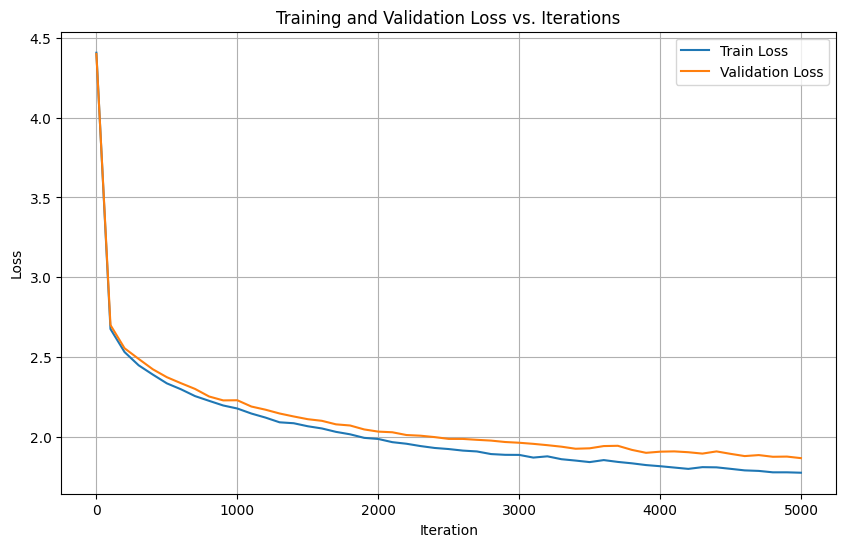

In [9]:
import matplotlib.pyplot as plt
# hyperparameters
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.2

model = LanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters()))
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Variables to store loss values and iterations
train_losses = []
val_losses = []
iterations = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']

        # Store losses and current iteration
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        iterations.append(iter)

        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # make the forward and the backward pass and evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()


### The models initialization needs to be fixed, currently the loss at the starting is around 4.4 which is too big, it means the model is getting unlucky in the initialization, in a good model initialization the the model should not predict wrong things with so much confidence. To reduce the loss, decrease the range of the enbeddings or include batch normalization. For the first few iterations the model is trying to just unlearn because of the very confident wrong embeddings.

In [10]:
# The the model predicted every next character with same confidence the loss would a little better, improving that is the next step
import math
print("Good starting loss is", -math.log(1.0/vocab_size), "currently the model has a loss of", losses )

Good starting loss is 4.174387269895637 currently the model has a loss of {'train': tensor(1.7733), 'val': tensor(1.8648)}


In [11]:
contextword = "Hello there"
print(m.generate(contextword, max_new_tokens=2000))

Hello there witorse hither rather,
And, dave-to me me reaccoty: res:
Withing-bese frome. them theingm ! Ho seadst thet are ock
Is all rauss agay.-Dordoing nut,
Ay the shenable for dickion:
Which enous mans a denten the more mode.
Who's are but wouless:
Whost dot hear tay priearm have! sham,
Now of stuch I'll fears indercht af youry:
Annce the
IfXe, what.

HENGBRIEST:
Why spet ad:
Peint, these faitels beart'd were of fight Diees,
Uttoning of thee, is me would, it me filling alld thou dage I nto to amm your and his sup alt anause.

NORD Londe:
WeHat litteve vories, that, that sair might may lay!

MARESTIL:
Wherewt the your you, whome!-'s wart whone skind good at begeam stembjoing;
The hand to
A treving me doo henhis lore deson.

ADd to cains you is.

OF ERCHARD:
Reclome wombering the his neck upon?
Ist and Doose coucks
Well plisind's my him.

POLO:
Naint one vater's
Welcombrobmoes not anyied the harkerss;
Those but her, say-cienty,
-will fortir, with be a st,
.

Preaken, you toseson:
The

In [12]:
# The data is not that gibrish anymore